**I. Merging all dF**

In [1]:
import pandas as pd
import numpy as np
from contextlib import contextmanager
import gc
import time


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object'
    ]
    df = pd.get_dummies(df,
                        columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows=num_rows)
    test_df = pd.read_csv('application_test.csv', nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv('bureau.csv', nrows=num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index(
        [e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({
        **num_aggregations,
        **cat_aggregations
    })
    bureau_agg.columns = pd.Index([
        'BURO_' + e[0] + "_" + e[1].upper()
        for e in bureau_agg.columns.tolist()
    ])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index([
        'ACTIVE_' + e[0] + "_" + e[1].upper()
        for e in active_agg.columns.tolist()
    ])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index([
        'CLOSED_' + e[0] + "_" + e[1].upper()
        for e in closed_agg.columns.tolist()
    ])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


# Preprocess previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv('previous_application.csv', nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({
        **num_aggregations,
        **cat_aggregations
    })
    prev_agg.columns = pd.Index([
        'PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()
    ])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index([
        'APPROVED_' + e[0] + "_" + e[1].upper()
        for e in approved_agg.columns.tolist()
    ])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index([
        'REFUSED_' + e[0] + "_" + e[1].upper()
        for e in refused_agg.columns.tolist()
    ])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(
        ['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg


# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv('installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index([
        'INSTAL_' + e[0] + "_" + e[1].upper()
        for e in ins_agg.columns.tolist()
    ])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg


# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv('credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(
        ['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [ ]:
%% time

# Let the process do its job and then collect the merged dF
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()
with timer("Save df"):
    df.to_csv('merged_df.csv.gz', compression='gzip', index=False)

**II. Load dF**

*II.1 Charging dataset* 

In [1]:
import pandas as pd
import gc
import re

# Pandas option to display dF efficiently
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 800)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 200)

df = pd.read_csv('merged_df.csv.gz', compression='gzip')

# Collect features
feats = [
    f for f in df.columns if f not in
    ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
]

# Create dF with all features without TARGET
train_df = df[df['TARGET'].notnull()][feats]
train_df = train_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Create dF TARGET
train_target = df[df['TARGET'].notnull()]['TARGET']

# Create dF test for submission to Kaggle Leaderboard
test_df = df[df['TARGET'].isnull()][feats]
test_df = test_df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

del df
gc.collect()

192

*II.2 Exploring dataset* 

In [2]:
print(('Trainset shape {} Testset shape {} Target shape {}').format(
    train_df.shape, test_df.shape, train_target.shape))

Trainset shape (307507, 795) Testset shape (48744, 795) Target shape (307507,)


In [3]:
train_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,...,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sentproposal_MIN,CC_NAME_CONTRACT_STATUS_Sentproposal_MAX,CC_NAME_CONTRACT_STATUS_Sentproposal_MEAN,CC_NAME_CONTRACT_STATUS_Sentproposal_SUM,CC_NAME_CONTRACT_STATUS_Sentproposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [4]:
train_target.value_counts()
# It returns us an imbalanced problem

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

In [5]:
24825 / 282682

0.08781952865764357

In [5]:
# Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [6]:
# Missing values statistics
missing_values = missing_values_table(train_df)
display(missing_values)

Your selected dataframe has 795 columns.
There are 616 columns that have missing values.


,Missing Values,% of Total Values
REFUSED_RATE_DOWN_PAYMENT_MEAN,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MAX,262339,85.3
REFUSED_RATE_DOWN_PAYMENT_MIN,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MEAN,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MAX,262339,85.3
REFUSED_AMT_DOWN_PAYMENT_MIN,262339,85.3
REFUSED_APP_CREDIT_PERC_VAR,258350,84.0
CC_AMT_PAYMENT_CURRENT_VAR,246888,80.3
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,246814,80.3
CC_AMT_DRAWINGS_ATM_CURRENT_VAR,246814,80.3


**III. A few feature engineering**

In [7]:
import numpy as np

# All the process below are storing a dF of correlation between features
# Correlation dF are processing with [simple features, log, square root, squared and cubic function]
corr_matrix = pd.concat([train_df, train_target], axis=1).corr()
print('Correlation matrix with simple features done')

corr_matrix_log = pd.concat([train_df.add(1).apply(np.log), train_target],
                            axis=1).corr()
print('Correlation matrix with log features done')

corr_matrix_sqrt = pd.concat(
    [train_df.add(1).apply(np.abs).apply(np.sqrt), train_target],
    axis=1).corr()
print('Correlation matrix with square root features done')

corr_matrix_sq = pd.concat([train_df.apply(lambda x: x**2), train_target],
                           axis=1).corr()
print('Correlation matrix with squared features done')

corr_matrix_cub = pd.concat([train_df.apply(lambda x: x**3), train_target],
                            axis=1).corr()
print('Correlation matrix with cubic features done')

Correlation matrix with simple features done
Correlation matrix with log features done
Correlation matrix with square root features done
Correlation matrix with squared features done
Correlation matrix with cubic features done


In [ ]:
# Concatenate the correlations values to the TARGET
corr = pd.concat([
    corr_matrix['TARGET'], corr_matrix_log['TARGET'],
    corr_matrix_sqrt['TARGET'], corr_matrix_sq['TARGET'],
    corr_matrix_cub['TARGET']
],
    names=['simple ft', 'log', 'sqrt', 'squared', 'cubic'],
    axis=1)

# Store the results in a csv
corr.to_csv('corr_matrix.csv')

In [6]:
# Use the results to analyse best correlation values
corr = pd.read_csv('corr_matrix.csv')
corr.columns = ['name', 'simple ft', 'log', 'sqrt', 'squared', 'cubic']
corr.drop(index=795, inplace=True)

# Drop features **2 and **3 because no results were probants
corr.drop(columns=['squared', 'cubic'], inplace=True)

In [7]:
# Display the best correlation and inversed correlation values
# Only the log and square root give useful results
display(corr.sort_values(by='log', ascending=False).head(10))
print('Best log correlated features')

display(corr.sort_values(by='sqrt', ascending=False).head(10))
print('Best sqrt correlated features')

display(corr.sort_values(by='log').head(10))
print('Best log inverse correlated features')

display(corr.sort_values(by='sqrt').head(10))
print('Best sqrt inverse correlated features')

,name,simple ft,log,sqrt
728,CC_CNT_DRAWINGS_CURRENT_VAR,0.062892,0.127765,0.103038
721,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,0.107692,0.122742,0.118708
726,CC_CNT_DRAWINGS_CURRENT_MEAN,0.082520,0.121307,0.106536
723,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,0.061123,0.114284,0.101205
725,CC_CNT_DRAWINGS_CURRENT_MAX,0.101389,0.113505,0.114335
659,CC_AMT_BALANCE_MIN,0.064163,0.101715,0.086067
709,CC_AMT_RECIVABLE_MIN,0.063610,0.097053,0.080776
714,CC_AMT_TOTAL_RECEIVABLE_MIN,0.063608,0.097053,0.080774
704,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,0.063236,0.096576,0.083905
676,CC_AMT_DRAWINGS_CURRENT_MEAN,0.058732,0.094024,0.095302


Best log correlated features


,name,simple ft,log,sqrt
721,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,0.107692,0.122742,0.118708
725,CC_CNT_DRAWINGS_CURRENT_MAX,0.101389,0.113505,0.114335
726,CC_CNT_DRAWINGS_CURRENT_MEAN,0.082520,0.121307,0.106536
728,CC_CNT_DRAWINGS_CURRENT_VAR,0.062892,0.127765,0.103038
661,CC_AMT_BALANCE_MEAN,0.087177,0.089290,0.102550
716,CC_AMT_TOTAL_RECEIVABLE_MEAN,0.086490,0.088224,0.101923
711,CC_AMT_RECIVABLE_MEAN,0.086478,0.088215,0.101910
706,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,0.086062,0.088316,0.101699
723,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,0.061123,0.114284,0.101205
676,CC_AMT_DRAWINGS_CURRENT_MEAN,0.058732,0.094024,0.095302


Best sqrt correlated features


,name,simple ft,log,sqrt
32,EXT_SOURCE_3,-0.178926,-0.183362,-0.181245
31,EXT_SOURCE_2,-0.160471,-0.162488,-0.161548
30,EXT_SOURCE_1,-0.155317,-0.159310,-0.157376
270,BURO_MONTHS_BALANCE_SIZE_MEAN,-0.080193,-0.092032,-0.088052
274,BURO_CREDIT_ACTIVE_Closed_MEAN,-0.079369,-0.078629,-0.079164
450,PREV_CODE_REJECT_REASON_XAP_MEAN,-0.073938,-0.074214,-0.074148
252,BURO_DAYS_CREDIT_UPDATE_MEAN,0.068929,-0.071429,-0.080425
314,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,0.027357,-0.070178,-0.038766
240,DAYS_EMPLOYED_PERC,-0.067952,-0.068802,-0.068423
332,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,-0.065154,-0.068585,-0.068951


Best log inverse correlated features


,name,simple ft,log,sqrt
32,EXT_SOURCE_3,-0.178926,-0.183362,-0.181245
31,EXT_SOURCE_2,-0.160471,-0.162488,-0.161548
30,EXT_SOURCE_1,-0.155317,-0.159310,-0.157376
247,BURO_DAYS_CREDIT_MEAN,0.089731,NaN,-0.097335
270,BURO_MONTHS_BALANCE_SIZE_MEAN,-0.080193,-0.092032,-0.088052
252,BURO_DAYS_CREDIT_UPDATE_MEAN,0.068929,-0.071429,-0.080425
10,DAYS_EMPLOYED,0.074957,NaN,-0.079669
274,BURO_CREDIT_ACTIVE_Closed_MEAN,-0.079369,-0.078629,-0.079164
9,DAYS_BIRTH,0.078242,NaN,-0.078564
245,BURO_DAYS_CREDIT_MIN,0.075248,NaN,-0.078482


Best sqrt inverse correlated features


In [8]:
import numpy as np

# Results shows us some features that can be pass to log
features_to_log = [
    'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1',
    'CC_CNT_DRAWINGS_CURRENT_VAR', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
    'CC_CNT_DRAWINGS_CURRENT_MEAN'
]

# Apply the transformation
train_df.loc[:, features_to_log] = train_df.loc[:,
                                                features_to_log].add(1).apply(np.log)
print('Features with log done')

Features with log done


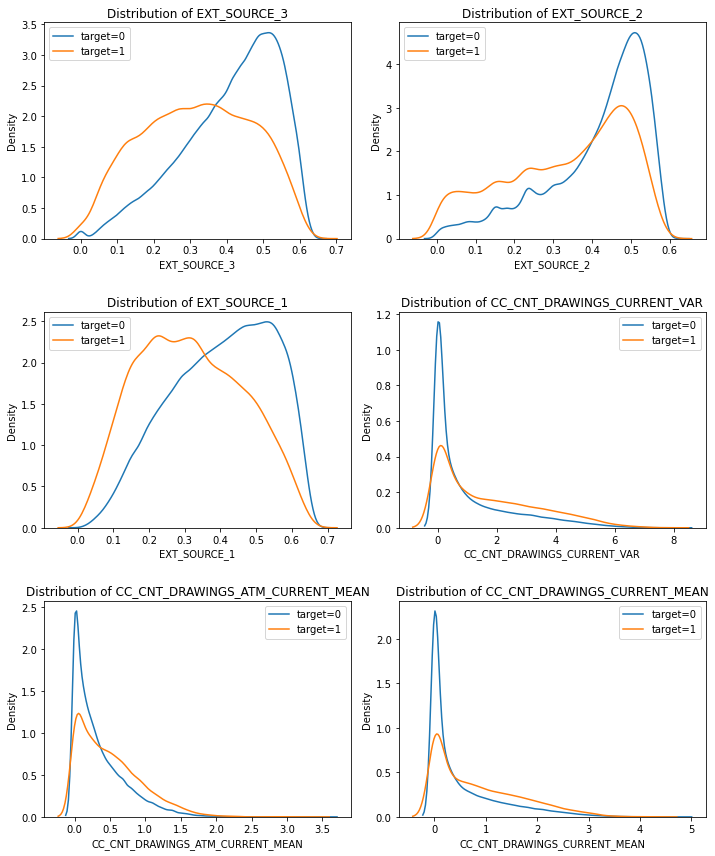

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

var = pd.concat([train_df, train_target], axis=1)
plt.figure(figsize=(10, 12))

# iterate through the sources
for i, source in enumerate(features_to_log):
    # create a new subplot for each source
    plt.subplot(3, 2, i + 1)
    # plot repaid loans
    sns.kdeplot(var.loc[var['TARGET'] == 0, source], label='target=0')
    # plot loans that were not repaid
    sns.kdeplot(var.loc[var['TARGET'] == 1, source], label='target=1')

    # Label the plots
    plt.title('Distribution of %s' % source)
    plt.xlabel('%s' % source)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout(h_pad=2.5)

**IV. Hyperopt bayesian optimization for hyperparameters**

In [55]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from lightgbm import LGBMClassifier
from hyperopt import STATUS_OK
import shap


def model_training(train_df, train_target):
    """Function to optimize hyperparameter of the LightGBM Classifier with a Bayesian approach.
    X : array or dF like with datas
    y: array or dF like with target to evaluate
    In output we collect some metrics as F1score, precision, recall and confusion_matrix"""

    # Declare variables to store essential outputs of the function
    pred_array = np.zeros(train_df.shape[0])
    metrics_results = dict()
    shap_values = list()
    shap_expect_values = list()
    tested_values = list()
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    # Go into the for loop and cross validation in 5 folds
    for i, (train_idx,
            test_idx) in enumerate(skf.split(train_df, train_target)):
        X_train, y_train = train_df.iloc[train_idx], train_target.iloc[
            train_idx]
        X_test, y_test = train_df.iloc[test_idx], train_target.iloc[test_idx]

        # Instanciate the LightGBM Classifier 
        model = LGBMClassifier()
        # And fit with training datas
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_train, y_train), (X_test, y_test)],
                  eval_metric='None',
                  verbose=100,
                  early_stopping_rounds=100)

        # Record the shap values to plot some graphs later
        explainer = shap.TreeExplainer(model)
        shap_values.append(explainer.shap_values(X_test))
        shap_expect_values.append(explainer.expected_value)
        tested_values.append(X_test)
        
        # Record the predictions done with testing datas
        pred_array[test_idx] = model.predict(X_test,
                                             num_iteration=int(
                                                 model.best_iteration_))

        # UNCOMMENT TO PREDICT AUC
        # pred_array[test_idx] = model.predict_proba(
        #    X_test, num_iteration=int(model.best_iteration_))
        print('************************************************************')
        auc = roc_auc_score(y_test, pred_array[test_idx])
        print('Fold %2d AUC : %.6f' % (i + 1, auc))
        print('************************************************************')

    # Record all the metrics in the metrics_result dictionnary
    metrics_results['auc'] = roc_auc_score(train_target, pred_array)
    metrics_results['f1_score'] = f1_score(train_target, pred_array)
    metrics_results['precision_score'] = precision_score(
        train_target, pred_array)
    metrics_results['recall'] = recall_score(train_target, pred_array)
    metrics_results['confusion_matrix'] = confusion_matrix(
        train_target, pred_array).ravel()  # Return (tn, fp, fn, tp)
    metrics_results['ft_importances'] = model.feature_importances_
    metrics_results['pred_array'] = pred_array
    metrics_results['shap_values'] = shap_values
    metrics_results['shap_expect_values'] = shap_expect_values
    metrics_results['tested_values'] = tested_values

    print('Model trained and predictions done')
    print('******************************************************************')

    return metrics_results

In [56]:
X = train_df.iloc[:10000, :]
y = train_target.iloc[:10000]

metrics = model_training(X, y)

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0391284	valid_1's binary_logloss: 0.264157
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.0391284	valid_1's binary_logloss: 0.264157


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


************************************************************
Fold  1 AUC : 0.509380
************************************************************
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0393934	valid_1's binary_logloss: 0.261944
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.0393934	valid_1's binary_logloss: 0.261944


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


************************************************************
Fold  2 AUC : 0.517187
************************************************************
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0395007	valid_1's binary_logloss: 0.268546
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.0395007	valid_1's binary_logloss: 0.268546


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


************************************************************
Fold  3 AUC : 0.507509
************************************************************
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0388037	valid_1's binary_logloss: 0.259135
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.0388037	valid_1's binary_logloss: 0.259135


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


************************************************************
Fold  4 AUC : 0.498374
************************************************************
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0384254	valid_1's binary_logloss: 0.284851
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.0384254	valid_1's binary_logloss: 0.284851
************************************************************
Fold  5 AUC : 0.506154
************************************************************
Model trained and predictions done
******************************************************************


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


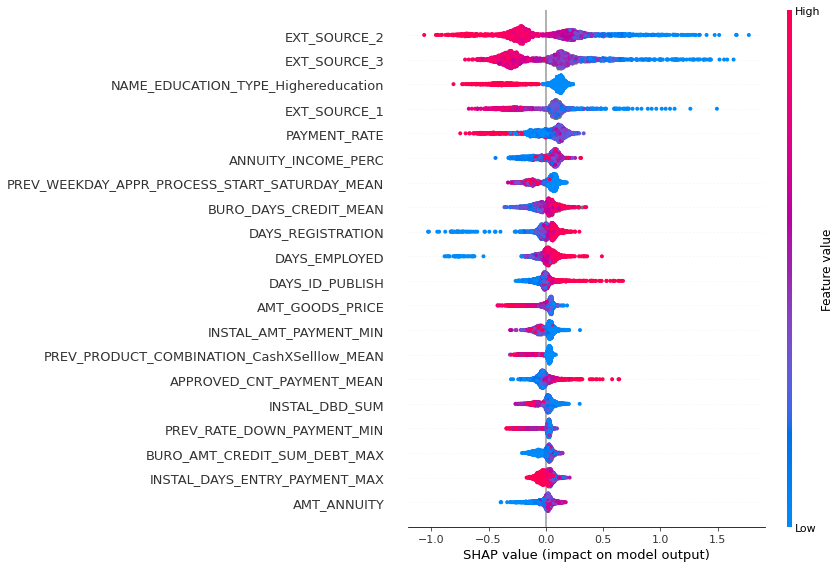

In [152]:
shap.summary_plot(metrics['shap_values'][0][1], metrics['tested_values'][0])

In [171]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(metrics['shap_expect_values'][3][0],
                 metrics['shap_values'][3][0][4, :], 
                 metrics['tested_values'][3].iloc[4])

In [77]:
from hyperopt import Trials, hp, tpe, fmin, space_eval
from hyperopt.pyll import scope as ho_scope
import hyperopt.pyll.stochastic

space_params = {
    #'is_unbalance': hp.choice('is_unbalance', [True, False]),
    'scale_pos_weight' : 0.087,
    'n_estimators':
    ho_scope.int(hp.quniform('n_estimators', 100, 15000, 1000)),
    'learning_rate':
    hp.loguniform('learning_rate', np.log(0.001), np.log(0.2)),
    'num_leaves':
    ho_scope.int(hp.quniform('num_leaves', 30, 150, 1)),
    'colsample_bytree':
    hp.loguniform('colsample_bytree', np.log(0.1), np.log(1.2)),
    'subsample':
    hp.loguniform('subsample', np.log(0.1), np.log(1.2)),
    'max_depth':
    ho_scope.int(hp.quniform('max_depth', 2, 10, 1)),
    'reg_alpha':
    hp.loguniform('reg_alpha', np.log(0.001), np.log(0.2)),
    'reg_lambda':
    hp.loguniform('reg_lambda', np.log(0.001), np.log(0.2)),
    'min_split_gain':
    hp.loguniform('min_split_gain', np.log(0.001), np.log(0.2)),
    'min_child_weight':
    hp.loguniform('min_child_weight', 10, 70),
}

def f(params):
    metrics = bayesian_optimizer(params)
    loss = -metrics['f1_score']
    return {'loss': loss, 'status': STATUS_OK}

trials = Trials()

best_params = fmin(fn=f,
                   space=space_params,
                   algo=tpe.suggest,
                   max_evals=10,
                   trials=trials,
                   verbose=1)

print('******************************************************************')
print('Best parameters with bayesian optimization are :', '\n')
print(best_params)
print('******************************************************************')

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:                    
[1]	training's binary_logloss: 0.400429	valid_1's binary_logloss: 0.400425
******************************************************************
Fold  1 AUC : 0.500000                                
******************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:                    
[1]	training's binary_logloss: 0.400429	valid_1's binary_logloss: 0.400425
******************************************************************
Fold  2 AUC : 0.500000                                
******************************************************************
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:                    
[1]	training's binary_logloss: 0.400428	valid_1's binary_logloss: 0.400432
*************************************************

KeyboardInterrupt: 

**V. Initiate the model**

In [ ]:
# Add metrics

# Hyperparemeter bayesian optimisation

# Use SHAP